# Using PLD method to extract/correct NIRCam/SW photometry for Visit 1

We have used pixel-level decorrelation (PLD) method in past to obtain and correct photometry from TESS. I think the basic principles can also be applied to obtain corrected lightcurves of NIRCam/SW channel. The idea is to obtain lightcurves for each pixel in the aperture and then use that as decorrelation vector. 

Now, there would be >3000 points in a given aperture. So, what we will do is perform a PCA on these points and then only use first few principle components as regressors.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import os
from tqdm import tqdm
from astropy.stats import mad_std
from astropy.timeseries import LombScargle
from astropy import units as u
import itertools

In [2]:
visit = 'NRCSW'

p1 = '/'.join(os.getcwd().split('/')[:-1])
pin = p1 + '/RateInts/Corr_' + visit
pout = p1 + '/NRCSW/Outputs/' + visit

segs = []
for i in range(6):
    if i < 9:
        segs.append('00' + str(i+1))
    else:
        segs.append('0' + str(i+1))

aprad = 85.

Let's first gather our data products. To save memory we will only work with a small segment of data -- and even from that small segment we will later choose only an aperture with the radius of 45 pixels and work only on that data.

Let's first find an aperture mask. To do this, we would need centroids. Fortunately, I already have centroids from previous aperture photometry. I will take meadian centroids from that analysis here.

Row center: 57.8100 pix; Column center: 547.2392 pix
Total number of pixels in the aperture: 19409.0000 pixels


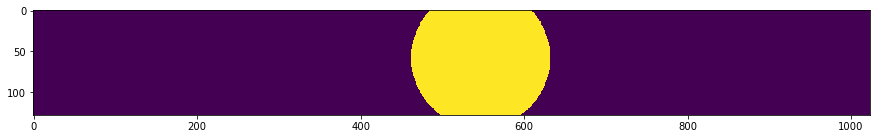

In [3]:
# Let's first find an aperture mask
cenr_all, cenc_all = np.loadtxt(pout + '/Photometry_' + visit + '_photutils.dat', usecols=(3,4), unpack=True)
cenr, cenc = np.nanmedian(cenr_all), np.nanmedian(cenc_all)

print('Row center: {:.4f} pix; Column center: {:.4f} pix'.format(cenr, cenc))

example_data = np.load(pin + '/Corrected_data_seg001.npy')
example_errs = np.load(pin + '/Corrected_errors_seg001.npy')

example_data, example_errs = np.nanmedian(example_data, axis=0), np.nanmedian(example_errs, axis=0)

_, _, aperture_mask = utils.aperture_mask(image=example_data, err=example_errs, cen_r=cenr, cen_c=cenc, rad=aprad)

print('Total number of pixels in the aperture: {:.4f} pixels'.format(np.sum(aperture_mask)))

# Let's plot the aperture mask
plt.figure(figsize=(15,5))
plt.imshow(aperture_mask, interpolation='None')

Okay, so the yellow region is our aperture; we now want to extract aperture photometry from this region along with pixel fluxes (that is lightcurve on each pixels inside the aperture).

Let's first extract the aperture photometry from this _fixed_ aperture.

100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


Text(0, 0.5, 'Relative flux')

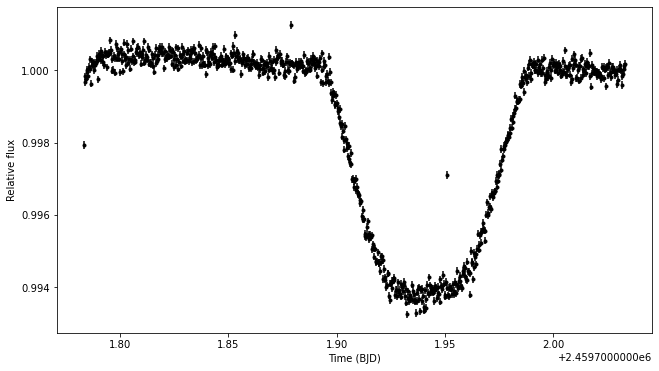

In [4]:
tim, fl, fle = np.array([]), np.array([]), np.array([])
for i in tqdm(range(len(segs))):
    # Loading and saving the times
    times_bjd = np.load(pin + '/Times_bjd_seg' + segs[i] + '.npy')
    tim = np.hstack((tim, times_bjd))

    # Loading the data
    corr_data = np.load(pin + '/Corrected_data_seg' + segs[i] + '.npy')
    corr_errs = np.load(pin + '/Corrected_errors_seg' + segs[i] + '.npy')
    # And extracting the aperture photometry
    for j in range(corr_data.shape[0]):
        ap_data, ap_err = corr_data[j,:,:]*aperture_mask, corr_errs[j,:,:]*aperture_mask
        fl, fle = np.hstack((fl, np.sum(ap_data))), np.hstack((fle, np.sqrt(np.sum(ap_err**2))))

tim = tim + 2400000.5

# And plotting the photometry
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(tim, fl/np.median(fl), yerr=fle/np.median(fl), fmt='.', c='k')
plt.xlabel('Time (BJD)')
plt.ylabel('Relative flux')

There are jumps -- but barely visible. The first jump in above image is near ~1.95 (+2.4597e6) BJD and the second jump is near 1.97 (+2.4597e6) BJD.

Now, let's store the pixel fluxes (i.e., lightcurves at each pixel inside the aperture).

In [5]:
pixel_fluxes = np.zeros((len(tim), int(np.sum(aperture_mask))))

# Location of aperture pixels
idxr, idxc = np.where(aperture_mask == 1)

# First, saving all data in a single big array
corr_data0 = np.load(pin + '/Corrected_data_seg' + segs[0] + '.npy')
for i in tqdm(range(len(segs)-1)):
    cor1 = np.load(pin + '/Corrected_data_seg' + segs[i+1] + '.npy')
    corr_data0 = np.vstack((corr_data0, cor1))

# And, now saving pixel fluxes
for i in tqdm(range(len(idxr))):
    pixel_fluxes[:,i] = corr_data0[:,idxr[i],idxc[i]]

100%|██████████| 19409/19409 [00:00<00:00, 56460.08it/s]


Okay, so now we have an array of pixel fluxes, we can use them as regressors to detrend our photometry. We first attempt to use _all_ 5201 vectors as regressors. This is definately too much, but I just want to see if they can explain those jumps or not.

(Ideally we want to use only out-of-eclipse data points to model the trends, but the thing here is that there is also a jump right in the middle of occultation. So, PLD model based only on out-of-eclipse data would not be accurate. Furthermore, in the end, we will perform a full analysis using PCA component of PLD model as a regressors in lightcurve fitting. So, we do not need to worry about this right now.)

Basically, we want to model the total flux as, $F(t) = A + \Sigma_i a_i \hat{P}_i (t)$, where $\hat{P} \equiv P_i(t) / \Sigma_i P_i(t)$ and $A$ is the baseline flux.

In [6]:
# First defining Phat
Phat = np.zeros(pixel_fluxes.shape)
Psum = np.sum(pixel_fluxes,axis=1)

for i in range(Phat.shape[0]):
    Phat[i,:] = pixel_fluxes[i,:]/Psum[i]

# Regress PLD on all datapoints. Add a matrix of ones to account for the A coefficient:
X = np.vstack(( np.ones(Phat.shape[0]), Phat.T ))

# Perform linear regression to obtain coefficients on out-of-transit data:
result = np.linalg.lstsq(X.T, fl, rcond=None)
coeffs = result[0]

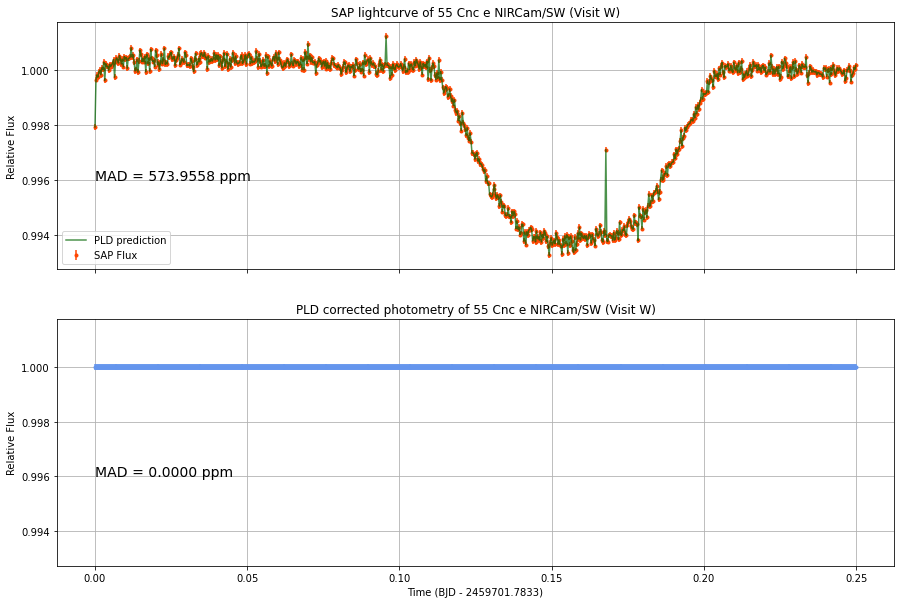

In [7]:
prediction = np.dot(coeffs, X)

fig, axs = plt.subplots(2, 1, figsize=(15,10), sharex=True, sharey=True)

axs[0].errorbar(tim-tim[0], fl/np.median(fl), yerr=fle/np.median(fl), fmt='.', c='orangered', label='SAP Flux')
axs[0].plot(tim-tim[0], prediction/np.median(fl), c='darkgreen', label='PLD prediction',alpha=0.7, zorder=10)
axs[0].set_ylabel('Relative Flux')
axs[0].set_title('SAP lightcurve of 55 Cnc e NIRCam/SW (Visit ' + str(visit[-1]) + ')')
axs[0].text(0., 0.996, 'MAD = {:.4f} ppm'.format(mad_std(fl/np.median(fl))*1e6), fontsize=14)
axs[0].legend(loc='best')
axs[0].grid()

axs[1].errorbar(tim-tim[0], fl/prediction, yerr=fle/prediction, fmt='.', c='cornflowerblue')
axs[1].set_xlabel('Time (BJD - {:.4f})'.format(tim[0]))
axs[1].set_ylabel('Relative Flux')
axs[1].set_title('PLD corrected photometry of 55 Cnc e NIRCam/SW (Visit ' + str(visit[-1]) + ')')
axs[1].text(0., 0.996, 'MAD = {:.4f} ppm'.format(mad_std(fl/prediction)*1e6), fontsize=14)
axs[1].grid()
#axs[1].set_xlim([22.38,22.42])

plt.savefig(pout + '/Figures_PCA/Without_PCA.png', dpi=500, facecolor='white')

Hahaha! Since there are very few points, the PLD prediction literally went through each datapoint -- very bad model. That's why PCA is needed.

Why we need PCA? Well, we can look at correlations among the pixel lightcurves below:

Text(0, 0.5, 'Element $j$')

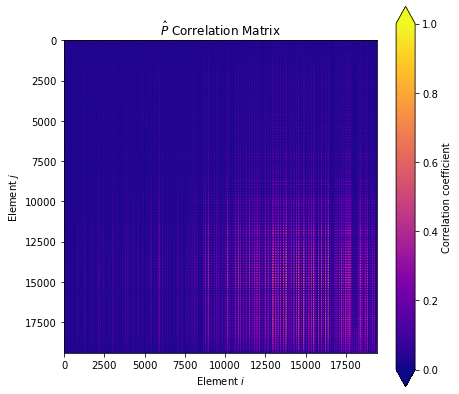

In [8]:
CorrelationMatrix = np.abs(np.corrcoef(Phat.T))

plt.figure(figsize=(7,7))
plt.title('$\hat{P}$ Correlation Matrix')
im = plt.imshow(CorrelationMatrix, cmap='plasma')
cbar = plt.colorbar(im, extend='both',label='Correlation coefficient')
plt.xlabel('Element $i$')
plt.ylabel('Element $j$')

You see? There is a lot of correlations (visible as reddish colors near diagonal in above plot). This means that there is a lot of extra information in the data. We can perform PCA to only take necessary information.

In [9]:
def standarize_data(input_data):
    """
    Standarize the dataset
    """
    output_data = np.copy(input_data)
    averages = np.median(input_data,axis=1)
    for i in range(len(averages)):
        sigma = mad_std(output_data[i,:])
        output_data[i,:] = output_data[i,:] - averages[i]
        output_data[i,:] = output_data[i,:]/sigma
    return output_data

def classic_PCA(Input_Data, standarize = True):
    """  
    classic_PCA function
    Description
    This function performs the classic Principal Component Analysis on a given dataset.
    """
    if standarize:
        Data = standarize_data(Input_Data)
    else:
        Data = np.copy(Input_Data)
    eigenvectors_cols,eigenvalues,eigenvectors_rows = np.linalg.svd(np.cov(Data))
    idx = eigenvalues.argsort()
    eigenvalues = eigenvalues[idx[::-1]]
    eigenvectors_cols = eigenvectors_cols[:,idx[::-1]]
    eigenvectors_rows = eigenvectors_rows[idx[::-1],:]
    # Return: V matrix, eigenvalues and the principal components.
    return eigenvectors_rows,eigenvalues,np.dot(eigenvectors_rows,Data)

V, eigenvalues, PCA = classic_PCA(Phat.T)

And let's see how the correlation matrix looks like,

Text(0, 0.5, 'Element $j$')

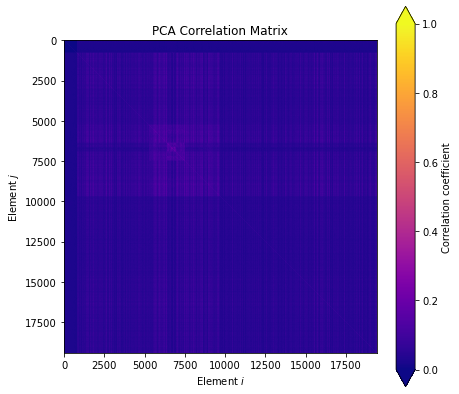

In [10]:
PCACorrelationMatrix = np.abs(np.corrcoef(PCA))

plt.figure(figsize=(7,7))
plt.title('PCA Correlation Matrix')
im = plt.imshow(PCACorrelationMatrix,cmap='plasma')
cbar = plt.colorbar(im, extend='both',label='Correlation coefficient')
plt.xlabel('Element $i$')
plt.ylabel('Element $j$')

It's almost diagonalised (of course it is hard to see, the matrix is very big (5201x5201))

Let's have a look at eigenvalues (we want to select only first few vectors)

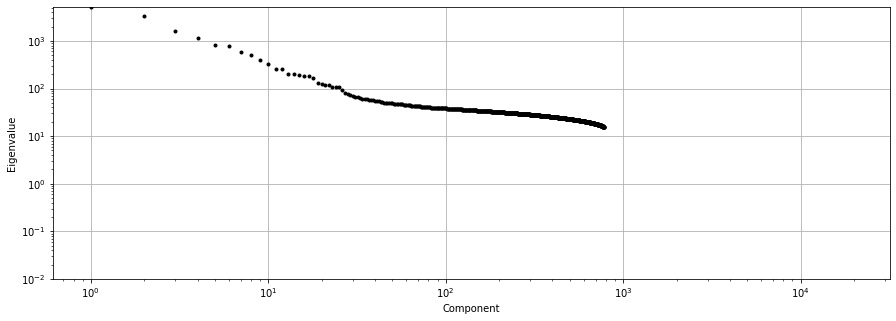

In [11]:
plt.figure(figsize=(15,5))
plt.errorbar(np.arange(len(eigenvalues))+1, eigenvalues, fmt='.', c='k')
plt.xlabel('Component')
plt.ylabel('Eigenvalue')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-2,np.max(eigenvalues)])
plt.grid()

The eigenvalue curve mostly flattens after first 10 components. So, in the following analysis, we will just use first 10 components.

Let's first analytically compute the PLD prediction model before doing a more thorough analysis.

In [12]:
X = np.vstack(( np.ones(len(fl)), PCA[:10,:] ))
# Fit:
result = np.linalg.lstsq(X.T, fl, rcond=None)
coeffs = result[0]

prediction = np.dot(coeffs, X)

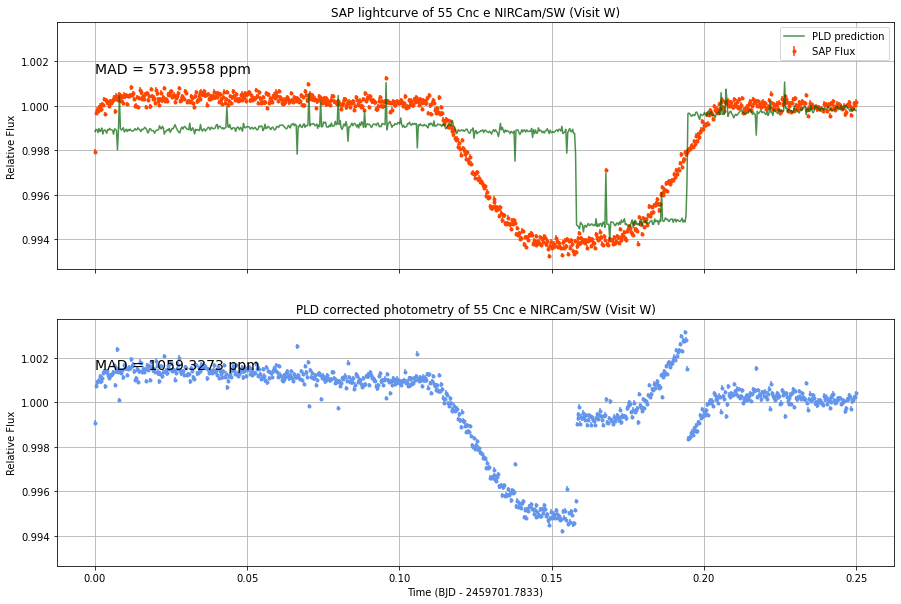

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(15,10), sharex=True, sharey=True)

axs[0].errorbar(tim-tim[0], fl/np.median(fl), yerr=fle/np.median(fl), fmt='.', c='orangered', label='SAP Flux')
axs[0].plot(tim-tim[0], prediction/np.median(fl), c='darkgreen', label='PLD prediction',alpha=0.7, zorder=10)
axs[0].set_ylabel('Relative Flux')
axs[0].set_title('SAP lightcurve of 55 Cnc e NIRCam/SW (Visit ' + str(visit[-1]) + ')')
axs[0].text(0., 1.0015, 'MAD = {:.4f} ppm'.format(mad_std(fl/np.median(fl))*1e6), fontsize=14)
axs[0].legend(loc='best')
axs[0].grid()

axs[1].errorbar(tim-tim[0], fl/prediction, yerr=fle/prediction, fmt='.', c='cornflowerblue')
axs[1].set_xlabel('Time (BJD - {:.4f})'.format(tim[0]))
axs[1].set_ylabel('Relative Flux')
axs[1].set_title('PLD corrected photometry of 55 Cnc e NIRCam/SW (Visit ' + str(visit[-1]) + ')')
axs[1].text(0., 1.0015, 'MAD = {:.4f} ppm'.format(mad_std(fl/prediction)*1e6), fontsize=14)
axs[1].grid()
#axs[1].set_xlim([22.38,22.42])

plt.savefig(pout + '/Figures_PCA/With_PCA.png', dpi=500, facecolor='white')

This is too bad! It looks like PLD won't work on this dataset!

Before going into the 2nd order PLD, let's look at how first 10 components of PCA looks like

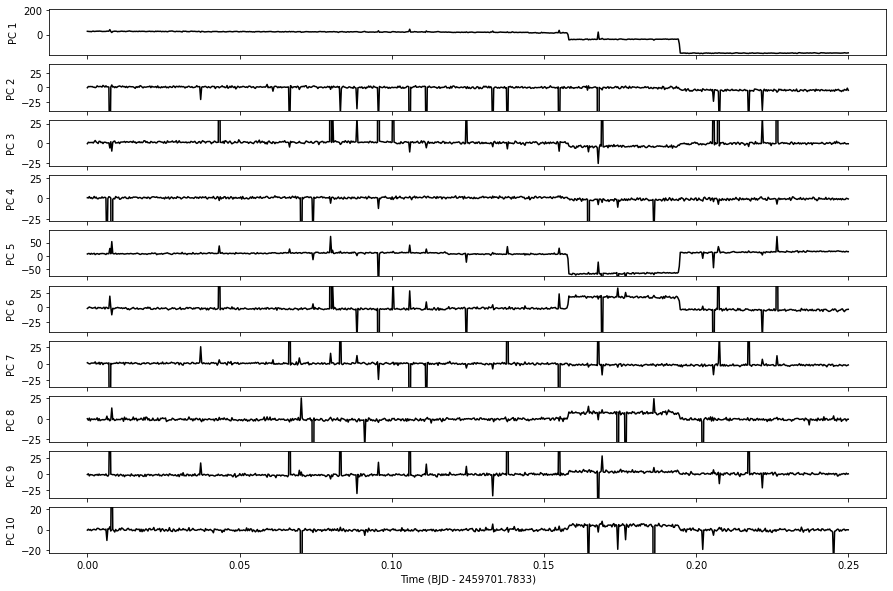

In [14]:
fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(15,10), sharex=True)
for i in range(10):
    axs[i].plot(tim - tim[0], PCA[i,:], 'k-')
    axs[i].set_ylabel('PC ' + str(i+1))
    med, std = np.nanmedian(PCA[i,:]), mad_std(PCA[i,:])
    axs[i].set_ylim([med-20*std, med+20*std])
plt.xlabel('Time (BJD - {:.4f})'.format(tim[0]))

np.save(pout + '/PCs.npy', PCA)
plt.savefig(pout + '/Figures_PCA/PCs.png', dpi=500, facecolor='white')